In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from keras import regularizers

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

dataTrait = df.drop(columns=["OsID", "Class"])# exclude OSID and Class Column
#print("Summary of dataTrait:\n",dataTrait.describe())


X = dataTrait.drop(['Trait'], axis=1) # exclude log_2FoldChange and trait columns
Y = dataTrait['Trait']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['PCC', 'log_2FoldChange', 'Leaf45DaysOldPlant', 'Shoot21DaysSeedling', 'Root10DaysSeedling', 
                 'Shoot35DaysSeedling', 'Root35DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Shoot14DaysSeedling', 
                 'Shoot10DaysSeedling', 'Root24DaysSeedling', 'Shoot17DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 
                 'Root52DaysSeedling', 'Leaf21DaysSeedling', 'ET', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41986, 20)
Shape of Y:
 (41986,)
Trait
cold            5887
drought        13772
heat            8297
salt            7662
stress          6229
submergence      139
dtype: int64


In [4]:
# prepare target data
def prepare_targets(y_train, y_test):
	ohe = OneHotEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = ohe.fit_transform(y_train)
	y_test_enc = ohe.transform(y_test)
	
	y_train_enc = y_train_enc.toarray()
	y_test_enc = y_test_enc.toarray()

	return y_train_enc, y_test_enc

In [5]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(6,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 6

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [6]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [7]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [9]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, y_train_fold_enc, epochs=100, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, y_val_fold_enc, verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, y_test_enc, verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1
Epoch 1/100
1885/1885 [==============================] - 16s 5ms/step - loss: 1.5872 - accuracy: 0.3239 - val_loss: 1.5706 - val_accuracy: 0.3283
Epoch 2/100
1885/1885 [==============================] - 8s 4ms/step - loss: 1.5725 - accuracy: 0.3262 - val_loss: 1.5749 - val_accuracy: 0.3283
Epoch 3/100
1885/1885 [==============================] - 8s 4ms/step - loss: 1.5724 - accuracy: 0.3262 - val_loss: 1.5727 - val_accuracy: 0.3283
Epoch 4/100
1885/1885 [==============================] - 8s 4ms/step - loss: 1.5723 - accuracy: 0.3262 - val_loss: 1.5716 - val_accuracy: 0.3283
Epoch 5/100
1885/1885 [==============================] - 8s 4ms/step - loss: 1.5716 - accuracy: 0.3262 - val_loss: 1.5699 - val_accuracy: 0.3283
Epoch 6/100
1885/1885 [==============================] - 9s 5ms/step - loss: 1.5715 - accuracy: 0.3262 - val_loss: 1.5698 - val_accuracy: 0.3283
Epoch 7/100
1885/1885 [==============================] - 8s 4ms/step - loss: 1.5708 - accurac

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

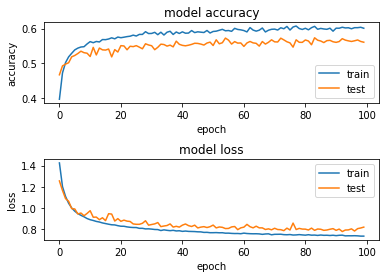

Final Test Accuracy: 0.5826357007026672


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

433/433 [==============================] - 1s 971us/step
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.49      0.52      1909
           1       0.57      0.51      0.54      4575
           2       0.75      0.88      0.81      2787
           3       0.40      0.36      0.38      2469
           4       0.57      0.67      0.62      2066
           5       0.77      0.96      0.86        50

    accuracy                           0.58     13856
   macro avg       0.60      0.65      0.62     13856
weighted avg       0.57      0.58      0.57     13856



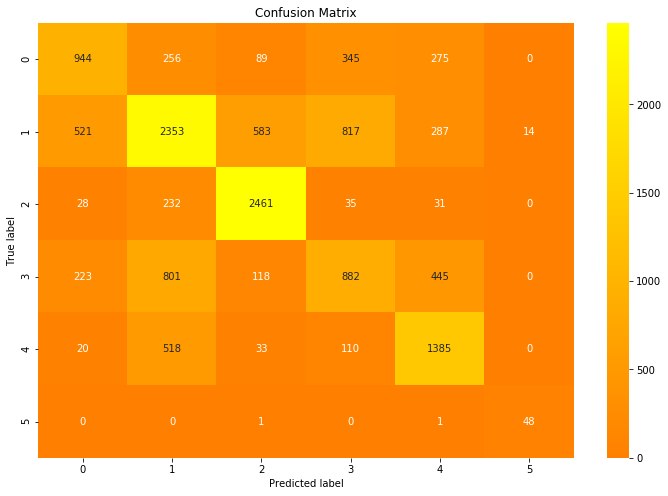

Confusion matrix:
 [[ 944  256   89  345  275    0]
 [ 521 2353  583  817  287   14]
 [  28  232 2461   35   31    0]
 [ 223  801  118  882  445    0]
 [  20  518   33  110 1385    0]
 [   0    0    1    0    1   48]]
Accuracy: 0.5826356812933026


In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]


# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label=np.argmax(y_pred, axis = 1)


rounded_ytestenc=np.argmax(y_test_enc, axis=1)

# Print the classification report
print("Classification report:\n", classification_report(rounded_ytestenc, y_pred_label))

cm = confusion_matrix(rounded_ytestenc, y_pred_label)
draw_confusion_matrix(cm)
print("Confusion matrix:\n", cm)

#Printing the accuracy
print("Accuracy:",accuracy(cm))


433/433 [==============================] - 0s 915us/step


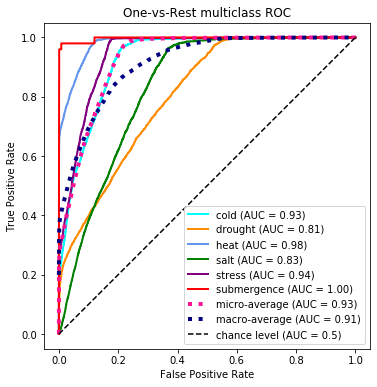

In [13]:

target_names = np.array(['cold', 'drought', 'heat', 'salt', 'stress', 'submergence'])

n_classes = len(np.unique(Y)) # 6

# predict probabilities for each class
y_score = best_model.predict(X_test)


# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# ROC curve using micro-averaged OvR
# Compute micro-average ROC curve and ROC area
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_enc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all OvR ROC curves together
fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red"])
for class_id, color, target_name in zip(range(n_classes), colors, target_names):
    plt.plot(
        fpr[class_id],
        tpr[class_id],
        color=color,
        lw=2,
        label=f"{target_name} (AUC = {roc_auc[class_id]:.2f})",
    )

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)



plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest multiclass ROC")
plt.legend(loc="lower right")
plt.show()